In [1]:
import logging
from ecmwf.datastores import Client

In [2]:
# instatiating logging
logging.basicConfig(level="INFO")

# fetching the data
client = Client()

# download util wrapped around the api
def download_total_precip(year, month, name):
    collection_id = 'reanalysis-era5-land'
    corn_belt_bbox = [43.5, -95.0, 40.5, -91.0] # N, W, S, E
    request = {
        'variable': 'total_precipitation',
        'year': year,
        'month': month,
        'day': [
            '01', '02', '03', '04', '05', '06',
            '07', '08', '09', '10', '11', '12',
            '13', '14', '15', '16', '17', '18',
            '19', '20', '21', '22', '23', '24',
            '25', '26', '27', '28', '29', '30', '31',
        ],
        'time': [
            '00:00', '01:00', '02:00', '03:00', '04:00', '05:00',
            '06:00', '07:00', '08:00', '09:00', '10:00', '11:00',
            '12:00', '13:00', '14:00', '15:00', '16:00', '17:00',
            '18:00', '19:00', '20:00', '21:00', '22:00', '23:00',
        ],
        'area': corn_belt_bbox,
        'format': 'unarchived',
    }

    client.retrieve(collection_id, request, target=f"./data/unzipped/{name}.grib")

years = [*[f"195{i}" for i in range(2, 10)], *[f"20{i}" for i in range(11, 15)]]

for year in years:
    # fetching july to get most significant month of the year in terms o
    download_total_precip(year, "07", f"percip_{year}")

INFO:ecmwf.datastores.processing:Request ID is 9529d080-0396-42d0-a096-4f8e7cf06344
INFO:ecmwf.datastores.processing:status has been updated to accepted
INFO:ecmwf.datastores.processing:status has been updated to running
INFO:ecmwf.datastores.processing:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-cache-1/2025-12-01/9cbb9273d43a34e5ed986210422d612c.zip
INFO:ecmwf.datastores.processing:Request ID is c8492ea8-0089-41d1-9b27-142817ed9bd8    
INFO:ecmwf.datastores.processing:status has been updated to accepted
INFO:ecmwf.datastores.processing:status has been updated to running
INFO:ecmwf.datastores.processing:status has been updated to successful
INFO:multiurl.base:Downloading https://object-store.os-api.cci2.ecmwf.int:443/cci2-prod-cache-1/2025-12-01/1f88652d0925c24d534ba3923c6ed78f.zip
INFO:ecmwf.datastores.processing:Request ID is d7c31fdb-e2ae-4d69-93be-2205285100ec    
INFO:ecmwf.datastores.processing:sta

In [2]:
# loading the data
import zipfile
import xarray as xr

zip_path = "./data/zipped/percip_1950.grib"  # your current file
with zipfile.ZipFile(zip_path, "r") as zf:
    print("Files in archive:", zf.namelist())
    # Extract everything to a folder
    zf.extractall("./data/unzipped/percip_1950/")

Files in archive: ['data.grib']


In [ ]:
# loading the data
ds = xr.open_dataset("./data/unzipped/percip_1950/data.grib", engine="cfgrib")

In [36]:
# preprocessing
def compute_wet_hour_average(ds, var_name='tp', threshold=0.1*0.001):
    """
    Metric 1: Mean Wet-Hour Intensity (Agricultural Focus).
    
    Logic:
    1. Filter out all hours where rain <= 0.1 mm (trace/zero).
    2. Calculate the mean of the REMAINING hours.
    
    Returns:
    A 2D DataArray (lat/lon) of average intensity (mm/hr) when it actually rains.
    """
    print(f"Computing Mean Wet-Hour Intensity (Threshold > {threshold}mm)...")
    
    # Select only wet hours; convert dry hours to NaN
    wet_hours = ds.where(ds[var_name] > threshold)
    
    # Calculate mean along the time dimension (ignoring NaNs automatically)
    intensity = wet_hours.mean(["time", "step"])
    
    return intensity

def compute_high_threshold_pot(ds, var_name='tp', quantile=0.95):
    """
    Metric 2: Peaks Over Threshold (POT) Average (Storm/Covariance Focus).
    
    Logic:
    1. Determine the 95th percentile (or other q) of WET HOURS at each location.
       (Note: We calculate quantile on wet hours only, not all hours, to avoid zero-bias).
    2. Filter for events exceeding this high threshold.
    3. Average those extremes.
    
    Returns:
    A 2D DataArray of the average magnitude of top-tier storms.
    """
    print(f"Computing POT Average (Events > {quantile*100}th percentile of wet hours)...")
    
    # 1. Isolate wet hours first
    wet_hours = ds.where(ds[var_name] > 0.01)
    
    # 2. Calculate the dynamic threshold for each pixel
    # Note: .quantile can be memory intensive on huge datasets. 
    # For terabyte-scale data, use dask or compute percentiles on a subset/climatology.
    thresholds = wet_hours.quantile(quantile, dim=['time', "step"], keep_attrs=True)
    
    # 3. Filter for events strictly greater than the local 95th percentile
    extreme_events = wet_hours.where(wet_hours > thresholds)
    
    # 4. Average the magnitude of these extreme events
    pot_average = extreme_events.mean(["time", "step"])
    
    return pot_average, thresholds


Computing Mean Wet-Hour Intensity (Threshold > 0.0001mm)...


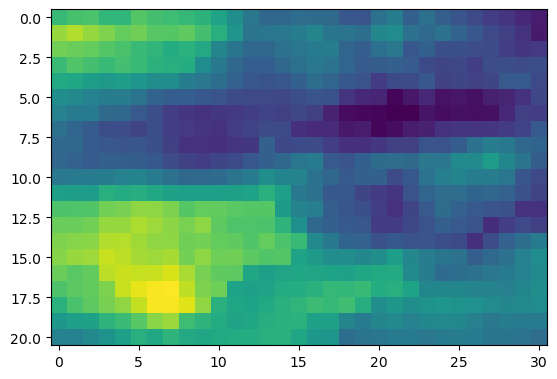

In [37]:
import matplotlib.pyplot as plt

# ds.where(ds.tp > .001, drop=True).mean(["time", "step"]).tp

res = compute_wet_hour_average(ds)
plt.imshow(res.tp.values)

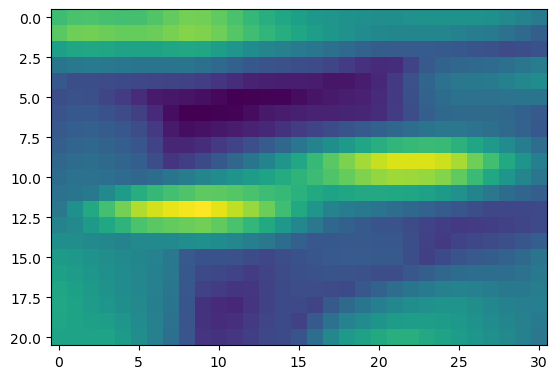

In [ ]:

plt.imshow(ds.max(["time", "step"]).tp.values)